In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pp
import os
from PIL import Image
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot as pp
from sklearn.tree import plot_tree
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay
)

In [2]:
data = pd.read_csv('~/AAI-510/Final Project/Data/diamond_data.csv')
data

,path_to_img,stock_number,shape,carat,clarity,colour,cut,polish,symmetry,fluorescence,lab,length,width,depth
0,web_scraped/cushion/2106452.jpg,2106452,cushion,0.55,SI2,N,VG,EX,VG,N,GIA,4.56,4.44,3.09
1,web_scraped/cushion/2042329.jpg,2042329,cushion,0.52,SI2,Y-Z,EX,EX,VG,F,GIA,4.40,4.31,2.99
2,web_scraped/cushion/2055268.jpg,2055268,cushion,0.50,SI1,L,VG,EX,VG,N,GIA,4.87,4.19,2.89
3,web_scraped/cushion/2128779.jpg,2128779,cushion,0.50,VS2,M,EX,EX,VG,F,GIA,4.73,4.28,2.84
4,web_scraped/cushion/2103991.jpg,2103991,cushion,0.51,SI1,M,EX,EX,VG,N,GIA,4.47,4.44,3.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48760,web_scraped/round/220439-45.jpg,220439-45,round,4.40,VVS1,E,EX,EX,EX,F,GIA,10.34,10.41,6.48
48761,web_scraped/round/227017-12.jpg,227017-12,round,4.40,IF,D,EX,EX,EX,N,GIA,10.49,10.55,6.47
48762,web_scraped/round/227035-26.jpg,227035-26,round,5.01,VVS2,D,EX,EX,EX,N,GIA,10.89,10.95,6.73
48763,web_scraped/round/227056-24.jpg,227056-24,round,5.19,FL,D,EX,EX,EX,N,GIA,11.16,11.22,6.77


In [3]:
data = pd.read_csv('~/AAI-510/Final Project/Data/diamond_data.csv')
data.drop(columns=['path_to_img','stock_number'],inplace=True) #Not required for regression task
data

,shape,carat,clarity,colour,cut,polish,symmetry,fluorescence,lab,length,width,depth
0,cushion,0.55,SI2,N,VG,EX,VG,N,GIA,4.56,4.44,3.09
1,cushion,0.52,SI2,Y-Z,EX,EX,VG,F,GIA,4.40,4.31,2.99
2,cushion,0.50,SI1,L,VG,EX,VG,N,GIA,4.87,4.19,2.89
3,cushion,0.50,VS2,M,EX,EX,VG,F,GIA,4.73,4.28,2.84
4,cushion,0.51,SI1,M,EX,EX,VG,N,GIA,4.47,4.44,3.05
...,...,...,...,...,...,...,...,...,...,...,...,...
48760,round,4.40,VVS1,E,EX,EX,EX,F,GIA,10.34,10.41,6.48
48761,round,4.40,IF,D,EX,EX,EX,N,GIA,10.49,10.55,6.47
48762,round,5.01,VVS2,D,EX,EX,EX,N,GIA,10.89,10.95,6.73
48763,round,5.19,FL,D,EX,EX,EX,N,GIA,11.16,11.22,6.77


In [4]:
print(data.isnull().sum())

#Since we have relatively lower number of NaNs, it is just better to drop the rows with NaN values
data.dropna(inplace=True)

shape              0
carat              0
clarity           38
colour             0
cut             1015
polish             2
symmetry           2
fluorescence       0
lab                0
length             0
width              0
depth              0
dtype: int64


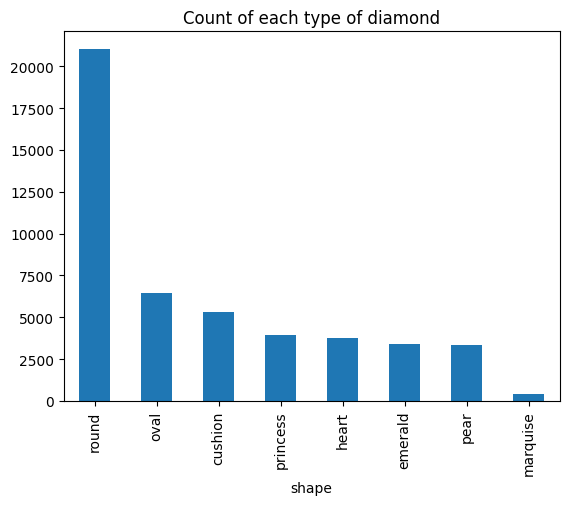

In [5]:
data['shape'].value_counts().plot(kind='bar')
pp.title('Count of each type of diamond')
pp.show()

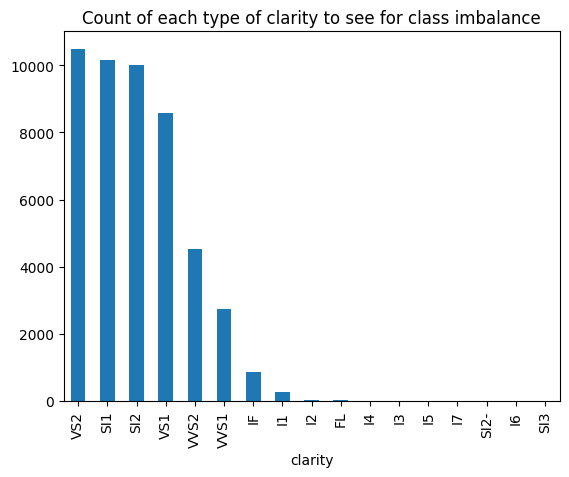

In [6]:
data['clarity'].value_counts().plot(kind='bar')
pp.title('Count of each type of clarity to see for class imbalance')
pp.show()

In [7]:
#As one can see, there are many categories which have negligible samples. The model obviously will not perform well on these by themselves.
#Instead, there are some groupings we can do. grouping the VVS, VS, SL, L together and have IL and IF separate. This makes sense intuitively
#And allows for usage in the real world since a person cannot distinguish between VVS1 and VVS2 anyway.

IF_ELSE_COND = [
    data['clarity'].str.contains('VVS', na=False),
    data['clarity'].str.contains('VS', na=False),
    data['clarity'].str.contains('SI', na=False),
    data['clarity'].str.contains('I', na=False),
    data['clarity'] == 'IF',
    data['clarity'] == 'FL'
]

final_clarity = ['VVS', 'VS', 'SL', 'L', 'IF', 'FL']

data['clarity_new'] = np.select(IF_ELSE_COND,final_clarity,default=np.NaN)
print(data['clarity_new'].unique())

data.drop('clarity',axis=1,inplace=True)
data.rename(columns={'clarity_new' : 'clarity'},inplace=True)

['SL' 'VS' 'VVS' 'L' 'FL']


In [8]:
data

,shape,carat,colour,cut,polish,symmetry,fluorescence,lab,length,width,depth,clarity
0,cushion,0.55,N,VG,EX,VG,N,GIA,4.56,4.44,3.09,SL
1,cushion,0.52,Y-Z,EX,EX,VG,F,GIA,4.40,4.31,2.99,SL
2,cushion,0.50,L,VG,EX,VG,N,GIA,4.87,4.19,2.89,SL
3,cushion,0.50,M,EX,EX,VG,F,GIA,4.73,4.28,2.84,VS
4,cushion,0.51,M,EX,EX,VG,N,GIA,4.47,4.44,3.05,SL
...,...,...,...,...,...,...,...,...,...,...,...,...
48760,round,4.40,E,EX,EX,EX,F,GIA,10.34,10.41,6.48,VVS
48761,round,4.40,D,EX,EX,EX,N,GIA,10.49,10.55,6.47,L
48762,round,5.01,D,EX,EX,EX,N,GIA,10.89,10.95,6.73,VVS
48763,round,5.19,D,EX,EX,EX,N,GIA,11.16,11.22,6.77,FL


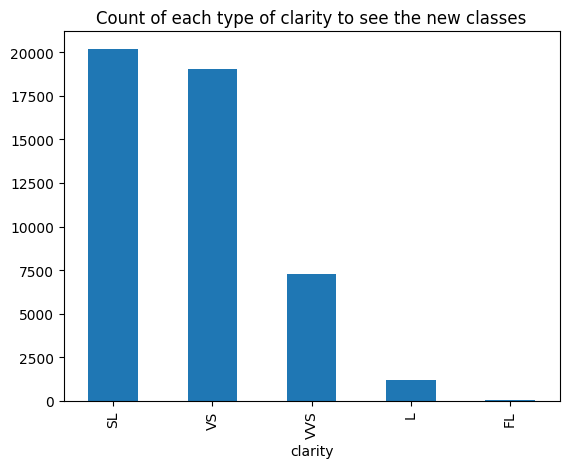

In [9]:
data['clarity'].value_counts().plot(kind='bar')
pp.title('Count of each type of clarity to see the new classes')
pp.show()

There is class imbalance in the data but it is expected since flawless and near flawless diamonds will always be rare.
To compensate, we will use balanced class weight in the models

In [10]:
#Encoding the categorical features
encoder = OrdinalEncoder() #We dont use one hot encoding to avoid extra dimensions which cause problems for Decision tree based algorithms
col_enc = data.select_dtypes(include=['object', 'category']).columns #Only the categorical columns
data[col_enc] = encoder.fit_transform(data[col_enc])

In [11]:
X = data.drop(columns=['clarity'])
y = data['clarity']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

To just compare, the training accuracy is:  0.3334119311483141
Testing Accuracy is:  0.3230640259876349
Precision score is:  0.5139231165214764
Recall score is:  0.3230640259876349
F1 score is:  0.3704829132101892
The classification report:

              precision    recall  f1-score   support

         0.0       0.01      0.25      0.02         8
         1.0       0.05      0.50      0.08       257
         2.0       0.67      0.26      0.38      4025
         3.0       0.48      0.37      0.42      3844
         4.0       0.23      0.34      0.28      1409

    accuracy                           0.32      9543
   macro avg       0.29      0.34      0.23      9543
weighted avg       0.51      0.32      0.37      9543



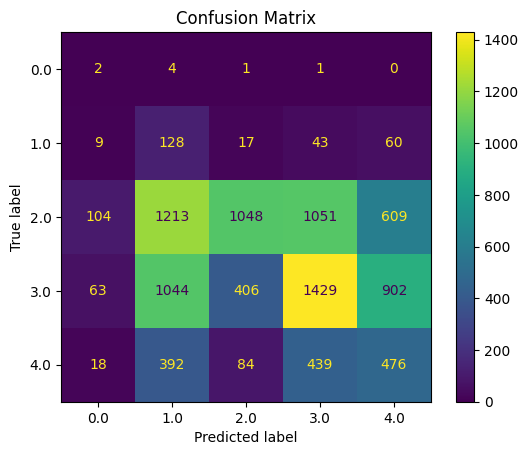

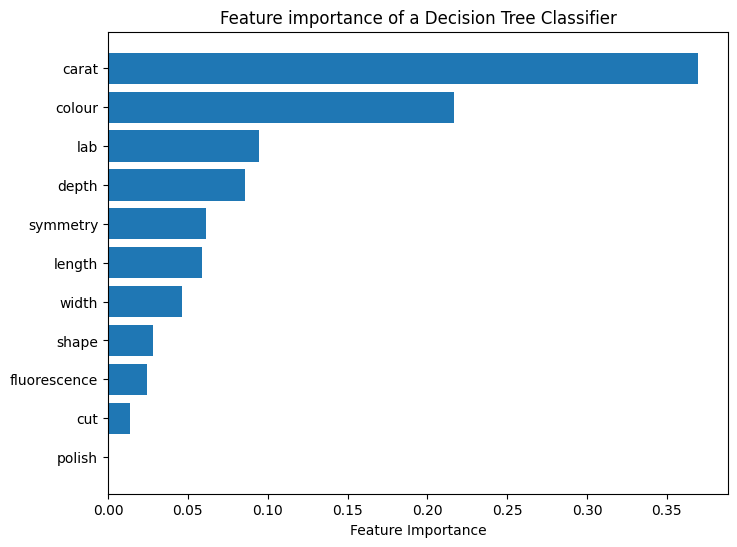

In [12]:
#Model 1, Decision Tree Classifier

model = DecisionTreeClassifier(max_depth=8,min_samples_split=20,min_samples_leaf=5,random_state=42,class_weight='balanced')
model.fit(X_train,y_train)

y_pred1 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred1))
print("Precision score is: ",precision_score(y_test,y_pred1,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred1,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred1,average='weighted'))
print("The classification report:\n")
print(classification_report(y_test,y_pred1))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

pp.title("Confusion Matrix")
pp.show()

importances = model.feature_importances_ #let's look at feature importance too to get a gauge of how the variables are explaining the Y
feature_names = X_train.columns
# Sort importances
index = np.argsort(importances)

pp.figure(figsize=(8, 6))
pp.barh(range(len(importances)), importances[index], align='center')
pp.yticks(range(len(importances)), [feature_names[i] for i in index])
pp.xlabel("Feature Importance")
pp.title("Feature importance of a Decision Tree Classifier")
pp.show()

#plot_tree(model,filled=True,max_depth=2,feature_names=X.columns)

In [13]:
#Since a few features have shown negligible importance wrt Y
#We will drop those features in an attempt to improve performance.
X_train_t = X_train.copy() #Creating copy for later use
X_test_t = X_test.copy()
X_train.drop(columns=['fluorescence','polish','cut','shape','width'],inplace=True)
X_test.drop(columns=['fluorescence','polish','cut','shape','width'],inplace=True)

To just compare, the training accuracy is:  0.4553171421834473
Testing Accuracy is:  0.4088860945195431
Precision score is:  0.5012578045369636
Recall score is:  0.4088860945195431
F1 score is:  0.43676655821409344
The classification report:

              precision    recall  f1-score   support

         0.0       0.06      0.38      0.11         8
         1.0       0.07      0.28      0.11       257
         2.0       0.63      0.40      0.49      4025
         3.0       0.49      0.41      0.45      3844
         4.0       0.24      0.44      0.31      1409

    accuracy                           0.41      9543
   macro avg       0.30      0.38      0.29      9543
weighted avg       0.50      0.41      0.44      9543



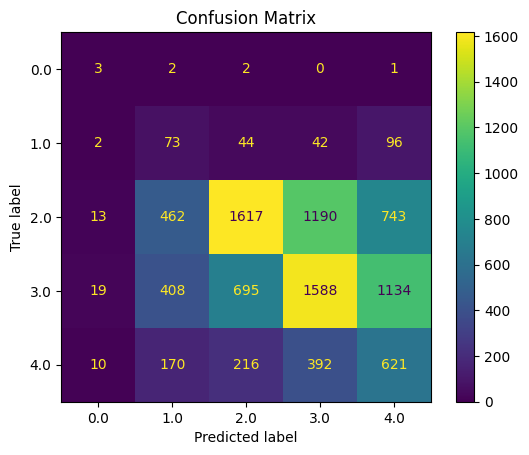

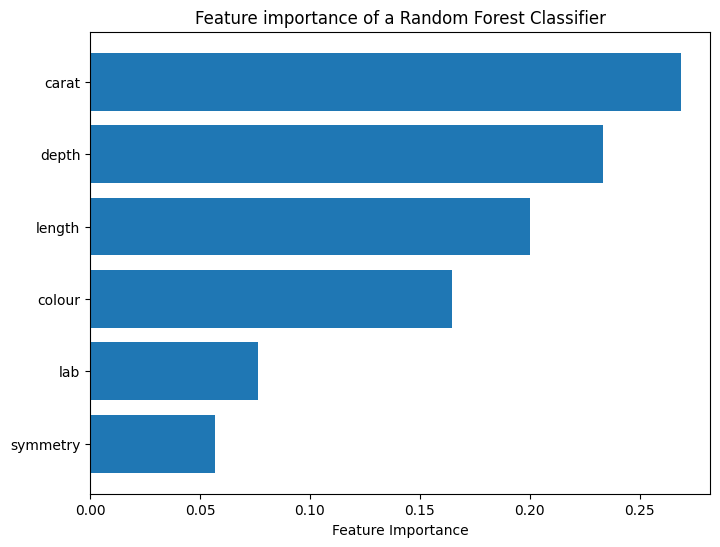

In [14]:
#Model 2, Random Forest Classifier

model = RandomForestClassifier(max_depth=10,min_samples_split=10,min_samples_leaf=5,random_state=42,class_weight='balanced')
model.fit(X_train,y_train)

y_pred2 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred2))
print("Precision score is: ",precision_score(y_test,y_pred2,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred2,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred2,average='weighted'))
print("The classification report:\n")
print(classification_report(y_test,y_pred2))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

pp.title("Confusion Matrix")
pp.show()

importances = model.feature_importances_ 
feature_names = X_train.columns

index = np.argsort(importances)

pp.figure(figsize=(8, 6))
pp.barh(range(len(importances)), importances[index], align='center')
pp.yticks(range(len(importances)), [feature_names[i] for i in index])
pp.xlabel("Feature Importance")
pp.title("Feature importance of a Random Forest Classifier")
pp.show()

#plot_tree(model,filled=True,max_depth=2,feature_names=X.columns)

To just compare, the training accuracy is:  0.5774057481202023
Testing Accuracy is:  0.5264591847427433
Precision score is:  0.5106718801271479
Recall score is:  0.5264591847427433
F1 score is:  0.4932824323764618
The classification report:

              precision    recall  f1-score   support

         0.0       0.08      0.12      0.10         8
         1.0       0.44      0.04      0.08       257
         2.0       0.57      0.61      0.59      4025
         3.0       0.49      0.64      0.56      3844
         4.0       0.39      0.07      0.11      1409

    accuracy                           0.53      9543
   macro avg       0.39      0.30      0.29      9543
weighted avg       0.51      0.53      0.49      9543



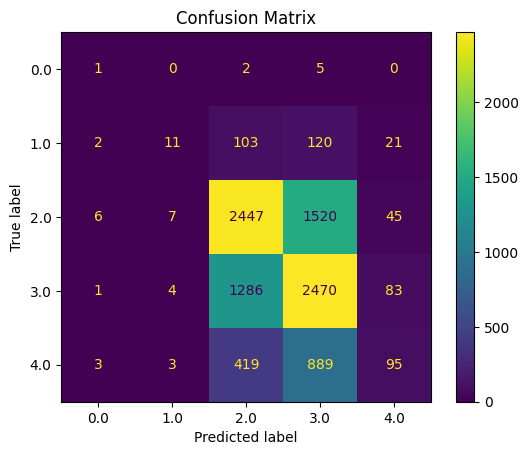

In [15]:
#Model 3, Gradient Boosting Classifier

model = GradientBoostingClassifier(max_depth=6,min_samples_split=10,min_samples_leaf=7,random_state=42,max_features='sqrt')
model.fit(X_train,y_train)

y_pred3 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred3))
print("Precision score is: ",precision_score(y_test,y_pred3,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred3,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred3,average='weighted'))
print("The classification report:\n")
print(classification_report(y_test,y_pred3))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

pp.title("Confusion Matrix")
pp.show()

#plot_tree(model,filled=True,max_depth=2,feature_names=X.columns)

C:\Users\Shreyas\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:32:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


To just compare, the training accuracy is:  0.5590138594147083
Testing Accuracy is:  0.5259352404904118
Precision score is:  0.5181489910221552
Recall score is:  0.5259352404904118
F1 score is:  0.490058007621224
The classification report:

              precision    recall  f1-score   support

         0.0       0.25      0.12      0.17         8
         1.0       0.63      0.05      0.09       257
         2.0       0.57      0.60      0.59      4025
         3.0       0.49      0.65      0.56      3844
         4.0       0.42      0.06      0.10      1409

    accuracy                           0.53      9543
   macro avg       0.47      0.30      0.30      9543
weighted avg       0.52      0.53      0.49      9543



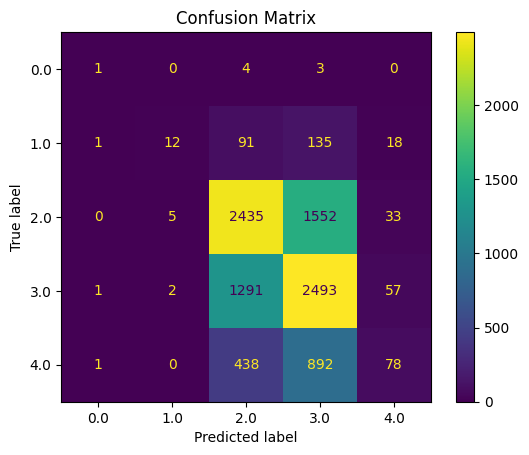

In [16]:
#Model 4, Gradient Boosting Classifier

model = XGBClassifier(n_estimators=1000,learning_rate=0.01,random_state=42,class_weight='balanced')
model.fit(X_train,y_train)

y_pred4 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred4))
print("Precision score is: ",precision_score(y_test,y_pred4,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred4,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred4,average='weighted'))
print("The classification report:\n")
print(classification_report(y_test,y_pred4))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

pp.title("Confusion Matrix")
pp.show()

In [17]:
c=0
print("Legend for the ordinal encoding:\n")
for i in encoder.categories_[7]:
    print(c," : ",i)
    c = c + 1

Legend for the ordinal encoding:

0  :  FL
1  :  L
2  :  SL
3  :  VS
4  :  VVS


As it is evident, the overall training AND testing accuracy are acceptable but not excellent. Through the heatmap of confusion matrix,
we can see that all models are showing similar performance to where they do well on SL and VS classes but poorly on FL,L and VVS. Since Gradient Boosting has best performance, I will pick that for the analysis of results. A couple of potential reasons on poor performance could be:

1. Too simple a model
2. Features are not explaining the target well.
3. High amount of noise in the data
4. Class imbalance
5. Other types of relationships work better on the data


In [19]:
#Addressing 1
#I will increase the max depth to make the model more complex and see if that improves performance
#Since there is class imbalance, just looking at accuracy will not suffice to see if the alterations are improving performance

model = GradientBoostingClassifier(max_depth=14,min_samples_split=20,min_samples_leaf=5,random_state=42)
model.fit(X_train,y_train)

y_pred5 = model.predict(X_test)

print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred5))
print("Precision score is: ",precision_score(y_test,y_pred5,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred5,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred5,average='weighted'))

#Increasing the max depth did improve performance but only slightly. Not sufficient to warrant a deeper tree. Additionally, it could lead to overfitting.

To just compare, the training accuracy is:  0.7996279703424245
Testing Accuracy is:  0.5021481714345594
Precision score is:  0.4807274693770128
Recall score is:  0.5021481714345594
F1 score is:  0.48478875721870485


Addressing 2

Feature importance on the Decision tree classifier did show lower for a number of features
However, we dropped those features and refitted the later algorithms but did not observe an improvement in performance.

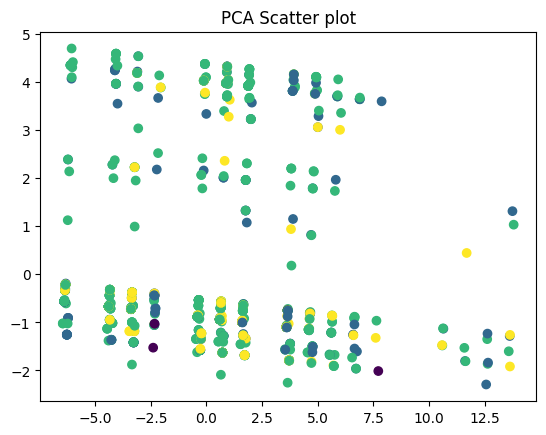

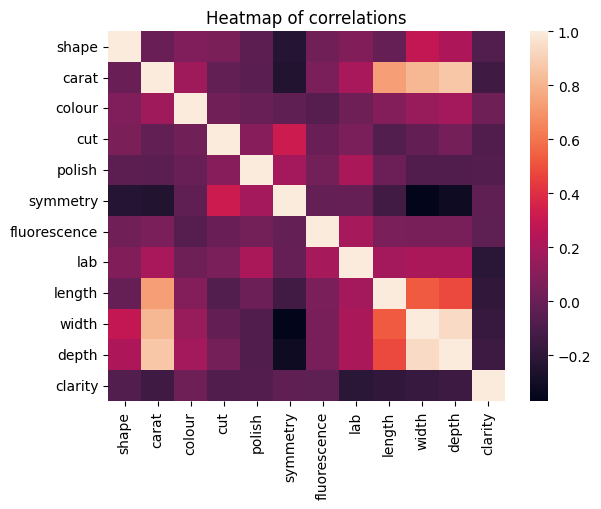

In [20]:
#Addressing 3
#I will create orthogonal independent PCA components from the features and see if there are overlaps
#if so, it will tell us that the data is noisy and there is class overlap which is making the performance suffer
from sklearn.decomposition import PCA
import seaborn as sn
pca = PCA(n_components=2)
comp = pca.fit_transform(X[:1000])

pp.scatter(comp[:,0], comp[:,1], c=y[:1000], cmap='viridis')
pp.title("PCA Scatter plot")
pp.show()
sn.heatmap(data.corr())
pp.title("Heatmap of correlations")
pp.show()
#There is overlap even in the first 1000 samples I selected. So this is one reason for the poor performance.
#The correlation is low across the board for clarity Y variable. It is good to note that there is some multicollinearity in the data
#So it is good we dropped those for later tree algorithms. Although it did not improve performance.

Addressing 4

We did check for class imbalance and while there was seen some, we tackled it by using balanced class weight in the model parameters


C:\Users\Shreyas\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


To just compare, the training accuracy is:  0.504335979459771
Testing Accuracy is:  0.5050822592476161
Precision score is:  0.4212486759321479
Recall score is:  0.5050822592476161
F1 score is:  0.4570023046896506


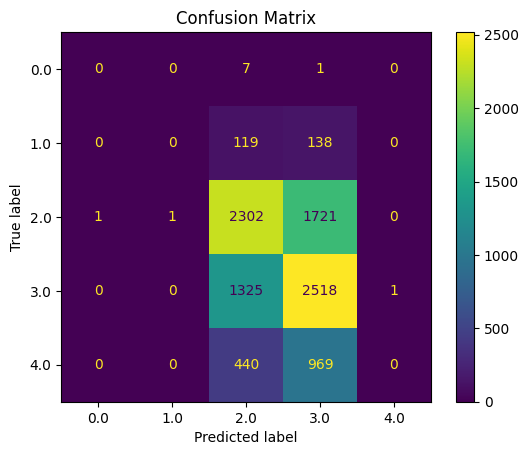

In [21]:
#Addressing 5
#Let us try to fit a multi class logistic regression, SVM and a basic Neural Network model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#model = MLPClassifier(hidden_layer_sizes=(64, 32),activation='relu',solver='adam',max_iter=1000,random_state=42)
#model = SVC(kernel='rbf', C=0.01, gamma='scale')  # RBF kernel by default
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000,random_state=42)
model.fit(X_train_t, y_train)

y_pred6 = model.predict(X_test_t)
print("To just compare, the training accuracy is: ",accuracy_score(y_train,model.predict(X_train_t)))
print("Testing Accuracy is: ",accuracy_score(y_test,y_pred6))
print("Precision score is: ",precision_score(y_test,y_pred6,average='weighted'))
print("Recall score is: ",recall_score(y_test,y_pred6,average='weighted'))
print("F1 score is: ",f1_score(y_test,y_pred6,average='weighted'))

ConfusionMatrixDisplay.from_estimator(model, X_test_t, y_test)

pp.title("Confusion Matrix")
pp.show()

The ballpark of accuracy is similar to other decision tree models from a metric perspective. However, one can see that it is performing worse than decision tree
in terms of individual classes, since it got 0 predictions right for class 0,1 and 4.

In [22]:
#Final compilation of all 4 models we fitted

models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
preds = [y_pred1, y_pred2, y_pred3, y_pred4]

# Collect metrics
rows = []
for name, pred in zip(models, preds):
    entry = {
        'Model': name,
        'Test Accuracy': accuracy_score(y_test, pred),
        'F1 Score': f1_score(y_test, pred, average='weighted'),
        'Recall': recall_score(y_test, pred, average='weighted'),
        'Precision': precision_score(y_test, pred, average='weighted')
    }
    rows.append(entry)

# Create and display table
final = pd.DataFrame(rows)
print(final)

               Model  Test Accuracy  F1 Score    Recall  Precision
0      Decision Tree       0.323064  0.370483  0.323064   0.513923
1      Random Forest       0.408886  0.436767  0.408886   0.501258
2  Gradient Boosting       0.526459  0.493282  0.526459   0.510672
3            XGBoost       0.525935  0.490058  0.525935   0.518149
